## Image网 Submission `128x128`

This contains a submission for the Image网 leaderboard in the `128x128` category.

In this notebook we:
1. Train on 1 pretext task: 
  - Train a network to do image inpatining on Image网's `/train`, `/unsup` and `/val` images. 
2. Train on 4 downstream tasks:
  - We load the pretext weights and train for `5` epochs.
  - We load the pretext weights and train for `20` epochs.
  - We load the pretext weights and train for `80` epochs.
  - We load the pretext weights and train for `200` epochs.
  
Our leaderboard submissions are the accuracies we get on each of the downstream tasks.

In [1]:
import json
import torch

import numpy as np

from functools import partial
from fastai2.basics import *
from fastai2.vision.all import *

In [2]:
torch.cuda.set_device(6)

## Pretext Task: Contrastive Learning

In [3]:
# Chosen parameters
lr=2e-2
sqrmom=0.99
mom=0.95
beta=0.
eps=1e-6
bs=64 
sa=1

m = xresnet18
act_fn = Mish
pool = MaxPool

nc=20

In [4]:
source = untar_data(URLs.IMAGEWANG_160)
len(get_image_files(source/'unsup')), len(get_image_files(source/'train'))

(7750, 14669)

In [5]:
# [s.name for s in (source/'train').ls()], [s.name for s in (source/'val').ls()]

In [6]:
def get_dbunch(size, bs, workers=8):
    path = URLs.IMAGEWANG_160 if size <= 160 else URLs.IMAGEWANG
    source = untar_data(path)
    
    files = get_image_files(source)
    
    tfms = [[PILImage.create, ToTensor, Resize(size)], 
            [lambda x: x.parent.name, Categorize()]]
    
    dsets = Datasets(files, tfms=tfms, splits=RandomSplitter(valid_pct=0.1)(files))
    
    batch_tfms = [IntToFloatTensor]
    dls = dsets.dataloaders(bs=bs, num_workers=workers, after_batch=batch_tfms)
    dls.path = source
    return dls

In [7]:
# Use the Ranger optimizer
opt_func = partial(ranger, mom=mom, sqr_mom=sqrmom, eps=eps, beta=beta)

In [8]:
size = 128
bs = 256

dbunch = get_dbunch(160, bs)
# dbunch.c = nc
dbunch.c = 128

In [9]:
len(dbunch.train.dataset)

23714

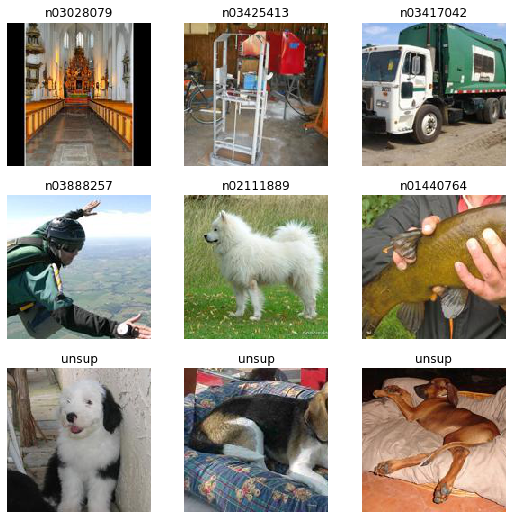

In [10]:
dbunch.show_batch()

In [11]:
#export
from pytorch_metric_learning import losses
class XentLoss(losses.NTXentLoss):
    def forward(self, output1, output2):
        stacked = torch.cat((output1, output2), dim=0)
        labels = torch.arange(output1.shape[0]).repeat(2)
        return super().forward(stacked, labels, None)
    
class ContrastCallback(Callback):
    run_before=Recorder
    def __init__(self, size=256, aug_targ=None, aug_pos=None, temperature=0.1):
        self.aug_targ = ifnone(aug_targ, get_aug_pipe(size, min_scale=0.7))
        self.aug_pos = ifnone(aug_pos, get_aug_pipe(size, min_scale=0.4))
        self.temperature = temperature
        
    def update_size(self, size):
        pipe_update_size(self.aug_targ, size)
        pipe_update_size(self.aug_pos, size)
        
    def begin_fit(self): 
        self.old_lf = self.learn.loss_func
        self.old_met = self.learn.metrics
        self.learn.metrics = []
        self.learn.loss_func = losses.NTXentLoss(self.temperature)
        
    def after_fit(self):
        self.learn.loss_fun = self.old_lf
        self.learn.metrics = self.old_met
        
    def begin_batch(self):
        xb, = self.learn.xb
        xb_targ = self.aug_targ(xb)
        xb_pos = self.aug_pos(xb)
        self.learn.xb = torch.cat((xb_targ, xb_pos), dim=0),
        self.learn.yb = torch.arange(xb_targ.shape[0]).repeat(2),
        

In [12]:
#export
def pipe_update_size(pipe, size):
    for tf in pipe.fs:
        if isinstance(tf, RandomResizedCropGPU):
            tf.size = size

In [13]:
#export
def get_aug_pipe(size, min_scale=0.4, stats=imagenet_stats, erase=True, **kwargs):
    tfms = [Normalize.from_stats(*stats), *aug_transforms(size=size, min_scale=min_scale, **kwargs)]
    if erase: tfms.append(RandomErasing(p=0.5, max_count=1, sh=0.2))
    return Pipeline(tfms)

In [14]:
m_part = partial(m, c_out=nc, act_cls=torch.nn.ReLU, sa=sa, sym=sym, pool=pool)

In [15]:
save_name = 'imagewang_contrast_simple'

In [16]:
aug = get_aug_pipe(size, min_scale=0.3, mult=1, max_lighting=0.4, stats=imagenet_stats)
aug2 = get_aug_pipe(size, min_scale=0.25, mult=2, max_lighting=0.4, stats=imagenet_stats)
cbs = ContrastCallback(size=size, aug_targ=aug, aug_pos=aug2)

learn = cnn_learner(dbunch, m_part, opt_func=opt_func,
                    metrics=[], loss_func=CrossEntropyLossFlat(), cbs=cbs, pretrained=False)

In [17]:
learn.unfreeze()
learn.fit_flat_cos(50, 2e-2, wd=1e-3)

epoch,train_loss,valid_loss,time
0,1.749258,1.353651,00:39
1,1.213385,1.334308,00:36
2,1.158012,0.935665,00:36
3,1.072069,1.007713,00:36
4,0.929264,1.009530,00:36
5,1.007939,0.710819,00:37
6,0.925269,0.955088,00:37
7,0.922556,1.299147,00:37
8,0.869419,0.681089,00:37
9,0.878081,0.842635,00:37


In [21]:
torch.save(learn.model[0].state_dict(), f'{save_name}.pth')

In [19]:
# learn.save(save_name)

## Visualizing what it does

In [23]:
# learn.load(save_name)
state_dict = torch.load(f'{save_name}.pth')
learn.model[0].load_state_dict(state_dict)

<All keys matched successfully>

In [24]:
xb,yb = dbunch.one_batch()

In [35]:
targ = aug(xb)
pos = aug2(xb)

In [36]:
nrm = Normalize.from_stats(*imagenet_stats)

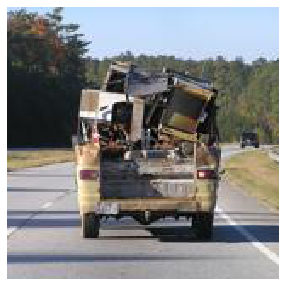

In [37]:
show_image(xb[0])

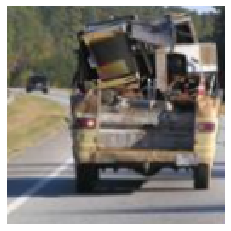

In [38]:
show_image(nrm.decode(targ)[0])

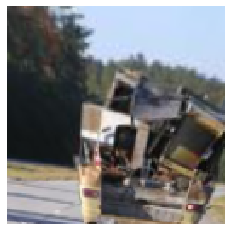

In [39]:
show_image(nrm.decode(pos)[0])

In [40]:
stack = torch.cat((targ,pos),dim=0)

In [41]:
with torch.no_grad():
    out = learn.model(stack)

In [42]:
F.cosine_similarity(out[:bs], out[bs:]).mean()

tensor(0.9568, device='cuda:6')

In [43]:
F.cosine_similarity(out[:bs], -out[bs:]).mean()

tensor(-0.9568, device='cuda:6')

In [44]:
F.cosine_similarity(out[:bs], out[bs:].flip(dims=[0])).mean()

tensor(0.0062, device='cuda:6')

## Downstream Task: Image Classification

In [45]:
def get_dbunch(size, bs, workers=8):
    path = URLs.IMAGEWANG_160 if size <= 160 else URLs.IMAGEWANG
    source = untar_data(path)
    
    files = get_image_files(source)
    
    item_aug = [RandomResizedCrop(size, min_scale=0.35), FlipItem(0.5)]
    tfms = [[PILImage.create, ToTensor, *item_aug], 
            [lambda x: x.parent.name, Categorize()]]
    
    dsets = Datasets(files, tfms=tfms, splits=GrandparentSplitter(valid_name='val')(files))
    
    batch_tfms = [IntToFloatTensor, Normalize.from_stats(*imagenet_stats)]
    dls = dsets.dataloaders(bs=bs, num_workers=workers, after_batch=batch_tfms)
    dls.path = source
    return dls

In [46]:
size=128
bs = 64
dbunch = get_dbunch(size, bs)

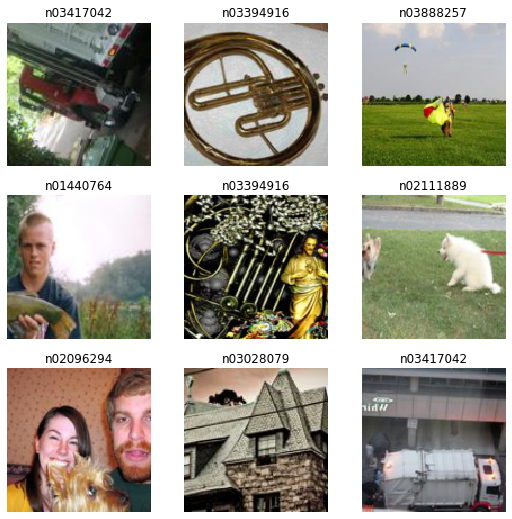

In [47]:
dbunch.show_batch()

### 5 Epochs

In [48]:
epochs = 5
runs = 1

In [49]:
for run in range(runs):
    print(f'Run: {run}')
    ch = nn.Sequential(nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(512, 20))
    learn = cnn_learner(dbunch, m_part, opt_func=opt_func,
            metrics=[accuracy,top_k_accuracy], loss_func=CrossEntropyLossFlat(),
            pretrained=False,
            config={'custom_head':ch})
    
    state_dict = torch.load(f'{save_name}.pth')
    learn.model[0].load_state_dict(state_dict)

    learn.unfreeze()
    learn.fit_flat_cos(epochs, 2e-2, wd=1e-3)

Run: 0


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.698967,5.534210,0.096208,0.358870,00:16
1,1.340348,5.355629,0.056757,0.539323,00:15
2,1.090503,2.860837,0.268516,0.721558,00:14
3,0.978959,4.256241,0.134640,0.528379,00:14
4,0.657331,2.148269,0.369560,0.801985,00:15


## Random weights - ACC = 0.337999	

In [27]:
for run in range(runs):
    print(f'Run: {run}')
    ch = nn.Sequential(nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(512, 20))
    learn = cnn_learner(dbunch, m_part, opt_func=opt_func,
            metrics=[accuracy,top_k_accuracy], loss_func=CrossEntropyLossFlat(),
            pretrained=False,
            config={'custom_head':ch})
    learn.unfreeze()
    learn.fit_flat_cos(epochs, 2e-2, wd=1e-3)

Run: 0


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.397326,4.106192,0.024434,0.352507,00:15
1,1.140212,2.822719,0.135149,0.641639,00:14
2,1.004816,4.800943,0.077628,0.355816,00:14
3,0.859049,3.429726,0.123696,0.613133,00:14
4,0.658352,2.196969,0.330618,0.794350,00:15


### 20 Epochs

In [50]:
epochs = 20
runs = 3

In [51]:
for run in range(runs):
    print(f'Run: {run}')
    ch = nn.Sequential(nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(512, 20))
    learn = cnn_learner(dbunch, m_part, opt_func=opt_func,
            metrics=[accuracy,top_k_accuracy], loss_func=CrossEntropyLossFlat(),
            pretrained=False,
            config={'custom_head':ch})
    learn.unfreeze()
    learn.fit_flat_cos(epochs, 2e-2, wd=1e-3)

Run: 0


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.411259,3.413633,0.089336,0.545431,00:15
1,1.132723,2.958089,0.133367,0.553321,00:15
2,0.993199,3.626117,0.109443,0.531942,00:15
3,0.874544,3.348081,0.158819,0.657419,00:15
4,0.818281,3.454900,0.186052,0.604225,00:15
5,0.750968,2.279198,0.315093,0.757954,00:15
6,0.678389,2.489367,0.312293,0.737083,00:15
7,0.657966,2.554108,0.286587,0.710613,00:15
8,0.629726,2.129390,0.350725,0.844744,00:14
9,0.573936,2.587999,0.340799,0.784933,00:15


Run: 1


KeyboardInterrupt: 

- Run 1: 0.610333
- Run 2: 0.618733
- Run 3: 0.605498

Average: **61.15%**

## 80 epochs

In [ ]:
epochs = 80
runs = 1

In [ ]:
for run in range(runs):
    print(f'Run: {run}')
    ch = nn.Sequential(nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(512, 20))
    learn = cnn_learner(dbunch, m_part, opt_func=opt_func,
            metrics=[accuracy,top_k_accuracy], loss_func=CrossEntropyLossFlat(),
            pretrained=False,
            config={'custom_head':ch})
    learn.unfreeze()
    learn.fit_flat_cos(epochs, 2e-2, wd=1e-3)

Accuracy: **62.18%**

### 200 epochs

In [ ]:
epochs = 200
runs = 1

In [ ]:
for run in range(runs):
        print(f'Run: {run}')
        ch = nn.Sequential(nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(512, 20))
        learn = cnn_learner(dbunch, m_part, opt_func=opt_func,
                metrics=[accuracy,top_k_accuracy], loss_func=CrossEntropyLossFlat(),
                config={'custom_head':ch})#, cbs=cbs)
        
        if dump: print(learn.model); exit()
#         if fp16: learn = learn.to_fp16()
        cbs = MixUp(mixup) if mixup else []
        learn.load(ss_name, strict=True)
        
        learn.freeze()
        learn.fit_flat_cos(epochs, lr, wd=1e-2, cbs=cbs)

Accuracy: **62.03%**